## Processing EEG signals and building ML models

#### Loading the dataset

In [ ]:
import os
import time
import pickle
import pandas as pd
import numpy as np

from scipy import signal
from scipy.signal import welch
from scipy.integrate import simps
from scipy.stats import f_oneway

#!pip install scikit-learn==0.20.3
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve

!pip install mne==0.22.0
import mne
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)
from mne.time_frequency import psd_welch
from mne.decoding import cross_val_multiscore

!pip install fooof
from fooof import FOOOFGroup
from fooof.bands import Bands
from fooof.analysis import get_band_peak_fg
from fooof.plts.spectra import plot_spectrum

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

C:\Users\ahonr\anaconda3\lib\site-packages\mne\fixes.py:988: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):
C:\Users\ahonr\anaconda3\lib\site-packages\mne\fixes.py:988: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):


In [ ]:
# Function to load data from each participant file
def read_eeg_signal_from_file(filename):
    x = pickle._Unpickler(open(filename, 'rb'))
    x.encoding = 'latin1'
    p = x.load()
    return p

In [ ]:
# Load only 22/32 participants with frontal videos recorded
files = []
for n in range(1, 23):
    s = ''
    if n < 10:
        s += '0'
    s += str(n)
    files.append(s)
print(files)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22']


In [ ]:
# 22x40 = 880 trials for 22 participants
labels = []
data = []

for i in files:
  filename = r"C:\Users\ahonr\Documents\deap\data_preprocessed_python\s" + i + ".dat"
  trial = read_eeg_signal_from_file(filename)
  labels.append(trial['labels'])
  data.append(trial['data'])

# Re-shape arrays into desired shapes
labels = np.array(labels)
labels = labels.flatten()
labels = labels.reshape(880, 4)

data = np.array(data)
data = data.flatten()
data = data.reshape(880, 40, 8064)

In [ ]:
# Double-check the new arrays
print("Labels: ", labels.shape) # trial x label
print("Data: ", data.shape) # trial x channel x data

Labels:  (880, 4)
Data:  (880, 40, 8064)


### Preprocessing

Get Valence and Arousal ratings
Valence describes the extent to which an emotion is positive or negative, whereas Arousal refers to its intensity, i.e., the strength of the associated emotional state.

In [ ]:
# Only extract Valence and Arousal ratings
df_label_ratings = pd.DataFrame({'Valence': labels[:,0], 'Arousal': labels[:,1]})
print(df_label_ratings.describe())

          Valence     Arousal
count  880.000000  880.000000
mean     5.218034    5.238898
std      2.093837    1.879631
min      1.000000    1.000000
25%      3.650000    3.895000
50%      5.040000    5.490000
75%      7.040000    6.795000
max      9.000000    9.000000


In [ ]:
print(df_label_ratings.head(15))

    Valence  Arousal
0      7.71     7.60
1      8.10     7.31
2      8.58     7.54
3      4.94     6.01
4      6.96     3.92
5      8.27     3.92
6      7.44     3.73
7      7.32     2.55
8      4.04     3.29
9      1.99     4.86
10     2.99     2.36
11     2.71     2.77
12     1.95     3.12
13     4.18     2.24
14     3.17     8.08


<Axes: >

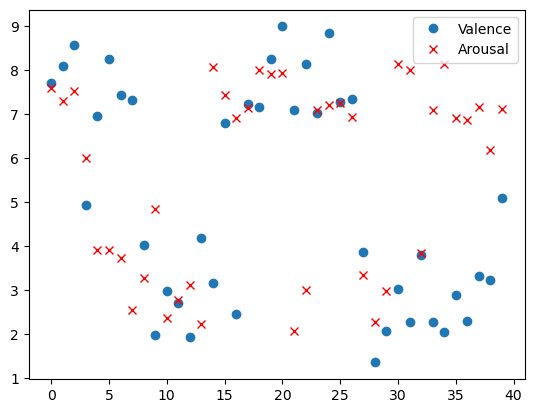

In [ ]:
# Plot the first 40 data rows (first participant)
df_label_ratings.iloc[0:40].plot(style=['o','rx'])

Check positive/negative cases
The combinations of Valence and Arousal can be converted to emotional states: High Arousal Positive Valence (Excited, Happy), Low Arousal Positive Valence (Calm, Relaxed), High Arousal Negative Valence (Angry, Nervous), and Low Arousal Negative Valence (Sad, Bored).

In [ ]:
# High Arousal Positive Valence dataset
df_hahv = df_label_ratings[(df_label_ratings['Valence'] >= np.median(labels[:,0])) & (df_label_ratings['Arousal'] >= np.median(labels[:,1]))]
# Low Arousal Positive Valence dataset
df_lahv = df_label_ratings[(df_label_ratings['Valence'] >= np.median(labels[:,0])) & (df_label_ratings['Arousal'] < np.median(labels[:,1]))]
# High Arousal Negative Valence dataset
df_halv = df_label_ratings[(df_label_ratings['Valence'] < np.median(labels[:,0])) & (df_label_ratings['Arousal'] >= np.median(labels[:,1]))]
# Low Arousal Negative Valence dataset
df_lalv = df_label_ratings[(df_label_ratings['Valence'] < np.median(labels[:,0])) & (df_label_ratings['Arousal'] < np.median(labels[:,1]))]

In [ ]:
# Check nummber of trials per each group
print("Positive Valence:", str(len(df_hahv) + len(df_lahv)))
print("Negative Valence:", str(len(df_halv) + len(df_lalv)))
print("High Arousal:", str(len(df_hahv) + len(df_halv)))
print("Low Arousal:", str(len(df_lahv) + len(df_lalv)))

Positive Valence: 457
Negative Valence: 423
High Arousal: 442
Low Arousal: 438


In [ ]:
# Check nummber of trials per each group
print("High Arousal Positive Valence:", str(len(df_hahv)))
print("Low Arousal Positive Valence:", str(len(df_lahv)))
print("High Arousal Negative Valence:", str(len(df_halv)))
print("Low Arousal Negative Valence:", str(len(df_lalv)))

High Arousal Positive Valence: 242
Low Arousal Positive Valence: 215
High Arousal Negative Valence: 200
Low Arousal Negative Valence: 223


In [ ]:
# Get mean and std of each group
print("HAHV")
print("Valence:", "Mean", np.round(df_hahv['Valence'].mean(),2), "STD", np.round(df_hahv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_hahv['Arousal'].mean(),2), "STD", np.round(df_hahv['Arousal'].std(),2))
print()
print("LAHV:")
print("Valence:", "Mean", np.round(df_lahv['Valence'].mean(),2), "STD", np.round(df_lahv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_lahv['Arousal'].mean(),2), "STD", np.round(df_lahv['Arousal'].std(),2))
print()
print("HALV:")
print("Valence:", "Mean", np.round(df_halv['Valence'].mean(),2), "STD", np.round(df_halv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_halv['Arousal'].mean(),2), "STD", np.round(df_halv['Arousal'].std(),2))
print()
print("LALV:")
print("Valence:", "Mean", np.round(df_lalv['Valence'].mean(),2), "STD", np.round(df_lalv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_lalv['Arousal'].mean(),2), "STD", np.round(df_lalv['Arousal'].std(),2))

HAHV
Valence: Mean 7.12 STD 1.04
Arousal: Mean 6.81 STD 0.84

LAHV:
Valence: Mean 6.67 STD 1.09
Arousal: Mean 3.87 STD 1.09

HALV:
Valence: Mean 3.19 STD 1.23
Arousal: Mean 6.79 STD 0.96

LALV:
Valence: Mean 3.57 STD 1.12
Arousal: Mean 3.47 STD 1.19


{'whiskers': [<matplotlib.lines.Line2D at 0x21c807d6cb0>,
 'caps': [<matplotlib.lines.Line2D at 0x21c807d71f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x21c807d6a10>,
 'medians': [<matplotlib.lines.Line2D at 0x21c807d7730>,
 'fliers': [<matplotlib.lines.Line2D at 0x21c807d79d0>,
 'means': []}

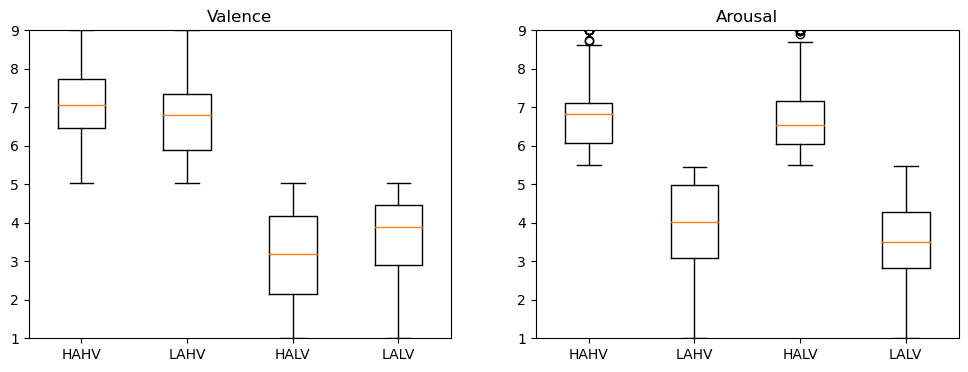

In [ ]:
# Valence and Arousal ratings between groups
fig, axs = plt.subplots(1, 2, figsize=(12,4))

axs[0].set_title("Valence")
axs[0].set_ylim(1, 9)
axs[0].boxplot([df_hahv['Valence'], df_lahv['Valence'], df_halv['Valence'], df_lalv['Valence']], labels=['HAHV','LAHV','HALV', 'LALV'])

axs[1].set_title("Arousal")
axs[1].set_ylim(1, 9)
axs[1].boxplot([df_hahv['Arousal'], df_lahv['Arousal'], df_halv['Arousal'], df_lalv['Arousal']], labels=['HAHV','LAHV','HALV', 'LALV'])

{'whiskers': [<matplotlib.lines.Line2D at 0x21c80a38250>,
 'caps': [<matplotlib.lines.Line2D at 0x21c80a38790>,
 'boxes': [<matplotlib.lines.Line2D at 0x21c80a07f70>,
 'medians': [<matplotlib.lines.Line2D at 0x21c80a38cd0>,
 'fliers': [<matplotlib.lines.Line2D at 0x21c80a38f70>,
 'means': []}

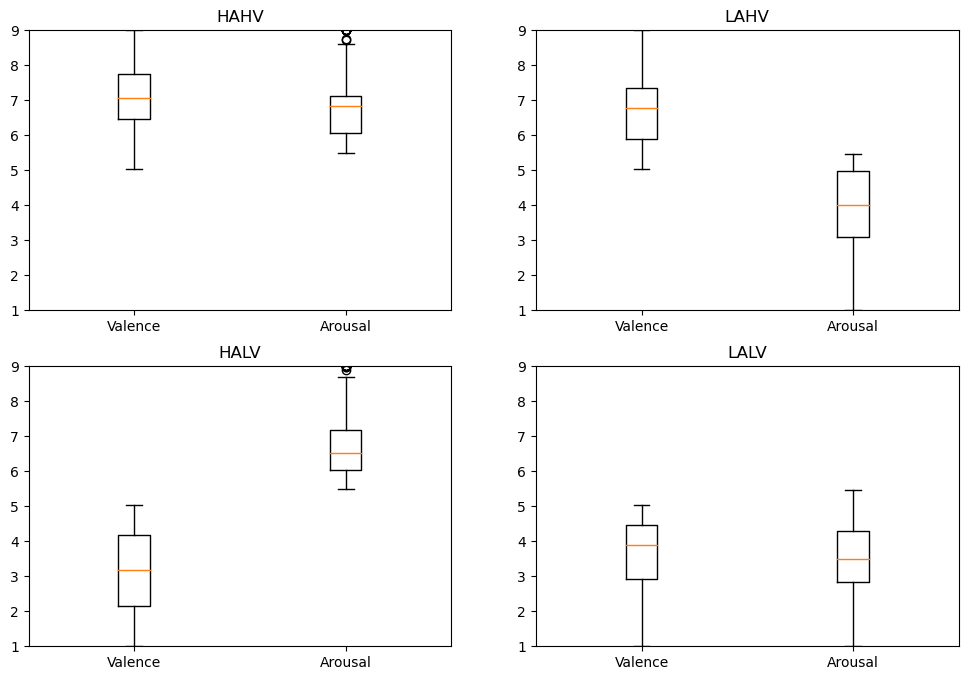

In [ ]:
# Valence and Arousal ratings per group
fig, axs = plt.subplots(2, 2, figsize=(12,8))

axs[0,0].set_title("HAHV")
axs[0,0].set_ylim(1, 9)
axs[0,0].boxplot([df_hahv['Valence'], df_hahv['Arousal']], labels=['Valence','Arousal'])

axs[0,1].set_title("LAHV")
axs[0,1].set_ylim(1, 9)
axs[0,1].boxplot([df_lahv['Valence'], df_lahv['Arousal']], labels=['Valence','Arousal'])

axs[1,0].set_title("HALV")
axs[1,0].set_ylim(1, 9)
axs[1,0].boxplot([df_halv['Valence'], df_halv['Arousal']], labels=['Valence','Arousal'])

axs[1,1].set_title("LALV")
axs[1,1].set_ylim(1, 9)
axs[1,1].boxplot([df_lalv['Valence'], df_lalv['Arousal']], labels=['Valence','Arousal'])

One hot encoding

In [ ]:
# Function to check if each trial has positive or negative valence
def positive_valence(trial):
    return 1 if labels[trial,0] >= np.median(labels[:,0]) else 0
# Function to check if each trial has high or low arousal
def high_arousal(trial):
    return 1 if labels[trial,1] >= np.median(labels[:,1]) else 0

In [ ]:
# Convert all ratings to boolean values
labels_encoded = []
for i in range (len(labels)):
  labels_encoded.append([positive_valence(i), high_arousal(i)])
labels_encoded = np.reshape(labels_encoded, (880, 2))
df_labels = pd.DataFrame(data=labels_encoded, columns=["Positive Valence", "High Arousal"])
print(df_labels.describe())

       Positive Valence  High Arousal
count        880.000000    880.000000
mean           0.519318      0.502273
std            0.499911      0.500279
min            0.000000      0.000000
25%            0.000000      0.000000
50%            1.000000      1.000000
75%            1.000000      1.000000
max            1.000000      1.000000


In [ ]:
# Dataset with only Valence column
df_valence = df_labels['Positive Valence']
# Dataset with only Arousal column
df_arousal = df_labels['High Arousal']

## EEG data

### Separate EEG and non-EEG data

The dataset includes 32 EEG channels and 8 peripheral physiological channels. The peripheral signals include: electrooculogram (EOG), electromyograms (EMG) of Zygomaticus and Trapezius muscles, GSR, respiration amplitude, blood volume by plethysmograph, skin temperature.

In [ ]:
eeg_channels = np.array(["Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"])
peripheral_channels = np.array(["hEOG", "vEOG", "zEMG", "tEMG", "GSR", "Respiration belt", "Plethysmograph", "Temperature"])

In [ ]:
eeg_data = []
for i in range (len(data)):
    for j in range (len(eeg_channels)):
        eeg_data.append(data[i,j])
eeg_data = np.reshape(eeg_data, (len(data), len(eeg_channels), len(data[0,0])))
print(eeg_data.shape)

(880, 32, 8064)


In [ ]:
peripheral_data = []
for i in range (len(data)):
    for j in range (32,len(data[0])):
        peripheral_data.append(data[i,j])
peripheral_data = np.reshape(peripheral_data, (len(data), len(peripheral_channels), len(data[0,0])))
print(peripheral_data.shape)

(880, 8, 8064)


Topomaps of subjects from HAHV - HALV - LAHV - LALV groups

In [ ]:
# Getting samples from 4 label groups, same subject
ev_data_hahv = mne.EvokedArray(eeg_data[1], info)
ev_data_halv = mne.EvokedArray(eeg_data[14], info)
ev_data_lahv = mne.EvokedArray(eeg_data[6], info)
ev_data_lalv = mne.EvokedArray(eeg_data[9], info)

In [ ]:
# Plot the topographies across different frequency bands
def plot_topo_psd(evData):
    evData.filter(4, 8)
    evData.plot_topomap(0.15, ch_type='eeg', average=60, time_unit='s')

    evData.filter(8, 12)
    evData.plot_topomap(0.15, ch_type='eeg', average=60, time_unit='s')

    evData.filter(12, 30)
    evData.plot_topomap(0.15, ch_type='eeg', average=60, time_unit='s')

    evData.filter(30, 63.9)
    evData.plot_topomap(0.15, ch_type='eeg', average=60, time_unit='s')

Topomaps of subjects from HAHV - HALV - LAHV - LALV groups by FOOOF
This will help plotting topomaps of all bands with the same scale of power spectra.

In [ ]:
# Deal with NaN values when the model cannot detect peaks in any given range
def check_nans(data, nan_policy='zero'):
    """Check an array for nan values, and replace, based on policy."""
    # Find where there are nan values in the data
    nan_inds = np.where(np.isnan(data))
    # Apply desired nan policy to data
    if nan_policy == 'zero':
        data[nan_inds] = 0
    elif nan_policy == 'mean':
        data[nan_inds] = np.nanmean(data)
    else:
        raise ValueError('Nan policy not understood.')
    return data

In [ ]:
# Plot the topographies across different frequency bands
def plot_psd_fooof(evData):
    fg = FOOOFGroup(peak_width_limits=[1, 6], min_peak_height=0.05, peak_threshold=2., max_n_peaks=6, verbose=False)
    bands = Bands({'theta': [4, 8],'alpha': [8, 12],'beta': [12, 30],'gamma': [30, 64]})
    freq_range = [1, 128]
    # Calculate power spectra across the the continuous data by MNE
    spectra, freqs = psd_welch(evData, fmin=1, fmax=128, tmin=0, tmax=250, n_overlap=150, n_fft=300)
    fg.fit(freqs, spectra, freq_range)
    # Plot the topographies across different frequency bands
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    for ind, (label, band_def) in enumerate(bands):
        # Extract the power peaks across channels for the current band
        band_power = check_nans(get_band_peak_fg(fg, band_def)[:, 1])
        # Create a topomap for the current oscillation band
        mne.viz.plot_topomap(band_power, evData.info, cmap=cm.viridis, axes=axes[ind], show=False);
        axes[ind].set_title(label + ' power', {'fontsize' : 16})

In [ ]:
def plot_psd_peak(evData):
    fg = FOOOFGroup(peak_width_limits=[1, 6], min_peak_height=0.05, peak_threshold=2., max_n_peaks=6, verbose=False)
    bands = Bands({'theta': [4, 8],'alpha': [8, 12],'beta': [12, 30],'gamma': [30, 64]})
    freq_range = [1, 128]
    # Calculate power spectra across the the continuous data by MNE
    spectra, freqs = psd_welch(evData, fmin=1, fmax=128, tmin=0, tmax=250, n_overlap=150, n_fft=300)
    fg.fit(freqs, spectra, freq_range)
    # Check the largest detected peaks within each band
    fig, axes = plt.subplots(1, 4, figsize=(20, 6))
    for ind, (label, band_def) in enumerate(bands):
        # Get the power values across channels for the current band
        band_power = check_nans(get_band_peak_fg(fg, band_def)[:, 1])
        # Extracted and plot the power spectrum model with the most band power
        fg.get_fooof(np.argmax(band_power)).plot(ax=axes[ind], add_legend=False)
        axes[ind].yaxis.set_ticklabels([])
        axes[ind].set_title('biggest ' + label + ' peak', {'fontsize' : 16})

Effective window size : 2.344 (s)


C:\Users\ahonr\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\ahonr\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\ahonr\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\ahonr\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay


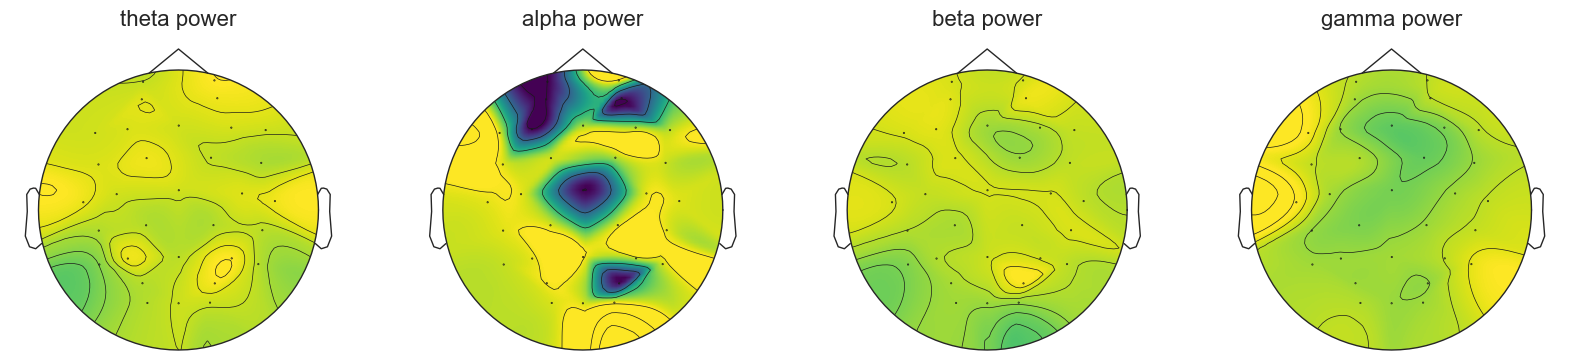

In [ ]:
plot_psd_fooof(ev_data_hahv)

Effective window size : 2.344 (s)


C:\Users\ahonr\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\ahonr\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\ahonr\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\ahonr\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay


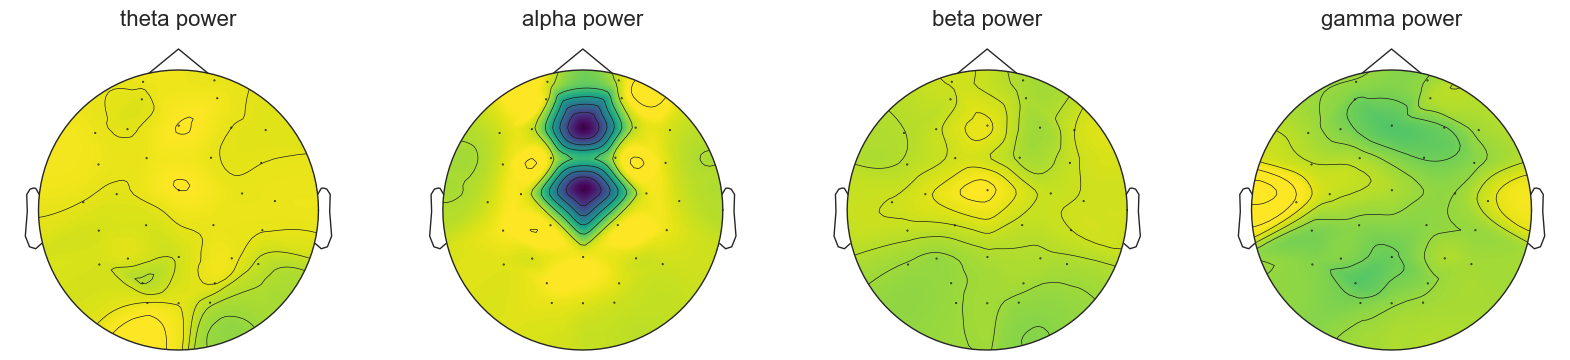

In [ ]:
plot_psd_fooof(ev_data_halv)

Effective window size : 2.344 (s)


C:\Users\ahonr\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\ahonr\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\ahonr\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\ahonr\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay


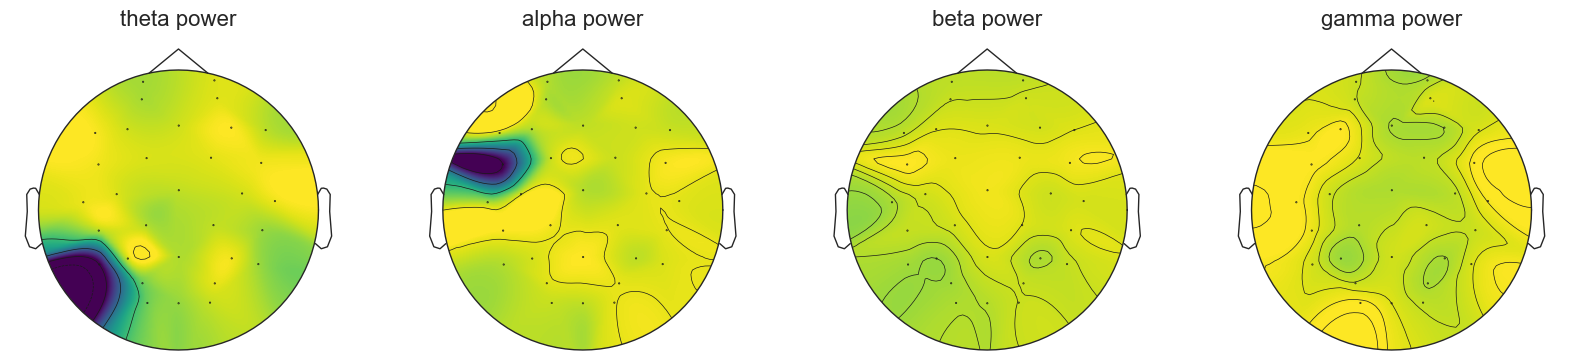

In [ ]:
plot_psd_fooof(ev_data_lahv)

Effective window size : 2.344 (s)


C:\Users\ahonr\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\ahonr\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\ahonr\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\ahonr\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay


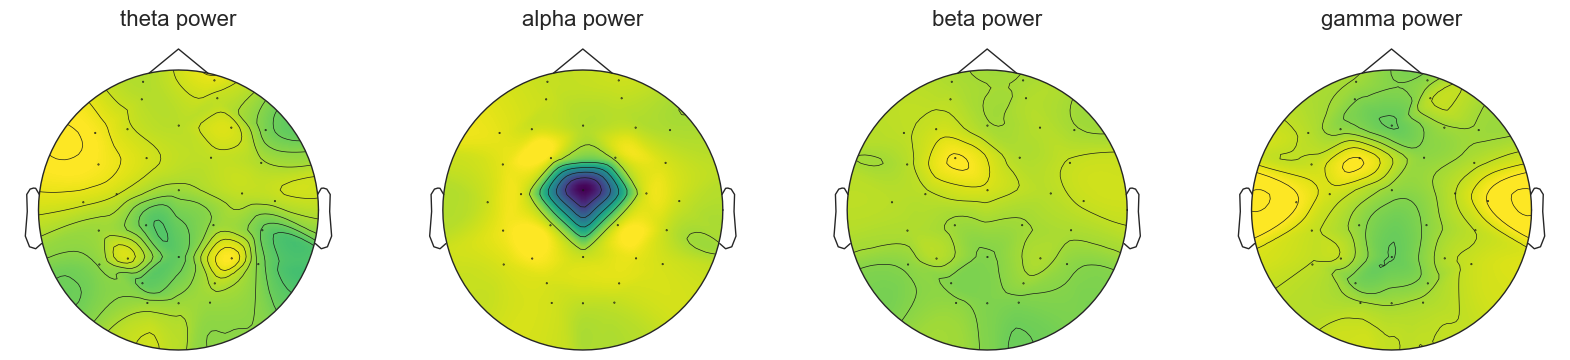

In [ ]:
plot_psd_fooof(ev_data_lalv)

### Train-test split and feature scaling

In [ ]:
# Split the data into training/testing sets
def split_train_test(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)
    return x_train, x_test, y_train, y_test

In [ ]:
# Feature scaling
def feature_scaling(train, test):
    sc = StandardScaler()
    train = sc.fit_transform(train)
    test = sc.transform(test)
    return train, test

### Cross-validation to select classifier

In [ ]:
band_names = np.array(["theta", "alpha", "beta", "gamma"])
channel_names = np.array(["left", "frontal", "right", "central", "parietal", "occipital"])
label_names = np.array(["valence", "arousal"])

In [ ]:
# Testing different kernels (linear, sigmoid, rbf, poly) to select the most optimal one
clf_svm = SVC(kernel = 'linear', random_state = 42, probability=True)

In [ ]:
# Testing different k (odd) numbers, algorithm (auto, ball_tree, kd_tree) and weight (uniform, distance) to select the most optimal one
clf_knn = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto')

In [ ]:
models = []
models.append(('SVM', clf_svm))
models.append(('k-NN', clf_knn))

In [ ]:
import time
def cross_validate_clf(df_x, df_y, scoring):
    # Train-test split
    x_train, x_test, y_train, y_test = split_train_test(df_x, df_y)
    # Feature scaling
    x_train, x_test = feature_scaling(x_train, x_test)
    names = []
    means = []
    stds = []
    times = []

    # Apply CV
    for name, model in models:
        start_time = time.time()
        kfold = model_selection.KFold(n_splits=5)
        cv_results = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
        t = (time.time() - start_time)
        times.append(t)
        means.append(cv_results.mean())
        stds.append(cv_results.std())
        names.append(name)

    return names, means, stds, times

Arousal - Accuracy

In [ ]:
cross_validate_clf(eeg_band_arr, df_arousal, 'accuracy')

(['SVM', 'k-NN'],
 [0.5827432467873066, 0.582690794649882],
 [0.032101393745388146, 0.04431488605048775],
 [0.4880342483520508, 0.18750405311584473])

Arousal - F1

In [ ]:
cross_validate_clf(eeg_band_arr, df_arousal, 'f1')

(['SVM', 'k-NN'],
 [0.5937644626169215, 0.5894382544174931],
 [0.06306024032148098, 0.05063265884937661],
 [0.4123094081878662, 0.14064717292785645])

Valence - Accuracy

In [ ]:
cross_validate_clf(eeg_band_arr, df_valence, 'accuracy')

(['SVM', 'k-NN'],
 [0.5748360870705481, 0.6168895882507213],
 [0.05271530492570222, 0.044277309553946674],
 [0.5590243339538574, 0.14062857627868652])

Valence - F1

In [ ]:
cross_validate_clf(eeg_band_arr, df_valence, 'f1')

(['SVM', 'k-NN'],
 [0.5663061143466444, 0.6284944434096976],
 [0.05453809485526526, 0.05807541894297642],
 [0.5596427917480469, 0.1406240463256836])

In [ ]:
def plot_cm(band, channel, label, clf):
    y_test2, y_predict = run_clf_cv(band, channel, label, clf)
    cm = confusion_matrix(y_test2, y_predict)
    print(cm)
    cr = classification_report(y_test2, y_predict)
    print(cr)

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()

    if (label == "valence"):
        classes = df_valence.unique().tolist()
    if (label == "arousal"):
        classes = df_arousal.unique().tolist()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
         plt.text(j, i, format(cm[i, j], 'd'),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Accuracy results

#### Valence

In [ ]:
print_accuracy('valence', 'knn')

Top 3 EEG regions with highest scores
left       69.11
right      68.29
central    67.48
dtype: float64

Top 2 bands with highest scores
beta     69.11
gamma    68.29
dtype: float64

EEG region with highest scores per each band
theta    central
alpha    central
beta        left
gamma      right
dtype: object

Band with highest scores per each EEG region
left          beta
frontal       beta
right        gamma
central      theta
parietal      beta
occipital     beta
dtype: object

        left  frontal  right  central  parietal  occipital
theta  56.91    63.41  57.72    67.48     56.91      55.28
alpha  58.54    52.85  60.16    65.85     62.60      55.28
beta   69.11    64.23  65.85    59.35     64.23      63.41
gamma  59.35    61.79  68.29    61.79     60.98      62.60


In [ ]:
print_accuracy('valence', 'svm')

Top 3 EEG regions with highest scores
central      60.16
occipital    60.16
frontal      58.54
dtype: float64

Top 2 bands with highest scores
gamma    60.16
theta    46.34
dtype: float64

EEG region with highest scores per each band
theta       left
alpha       left
beta        left
gamma    central
dtype: object

Band with highest scores per each EEG region
left         gamma
frontal      gamma
right        gamma
central      gamma
parietal     gamma
occipital    gamma
dtype: object

        left  frontal  right  central  parietal  occipital
theta  46.34    43.09  41.46    39.84     46.34      43.90
alpha  46.34    40.65  42.28    39.84     45.53      43.90
beta   46.34    43.09  45.53    44.72     42.28      45.53
gamma  52.03    58.54  46.34    60.16     47.15      60.16


#### Arousal

In [ ]:
print_accuracy('arousal', 'knn')

Top 3 EEG regions with highest scores
central     64.23
parietal    64.23
frontal     61.79
dtype: float64

Top 2 bands with highest scores
theta    64.23
beta     64.23
dtype: float64

EEG region with highest scores per each band
theta     central
alpha     central
beta     parietal
gamma     frontal
dtype: object

Band with highest scores per each EEG region
left         gamma
frontal      gamma
right        gamma
central      theta
parietal      beta
occipital    gamma
dtype: object

        left  frontal  right  central  parietal  occipital
theta  55.28    60.16  56.10    64.23     58.54      55.28
alpha  51.22    56.10  50.41    59.35     57.72      51.22
beta   52.03    55.28  52.03    55.28     64.23      55.28
gamma  57.72    61.79  58.54    56.91     61.79      58.54


In [ ]:
print_accuracy('arousal', 'svm')

Top 3 EEG regions with highest scores
left        61.79
parietal    60.16
central     54.47
dtype: float64

Top 2 bands with highest scores
gamma    61.79
alpha    60.16
dtype: float64

EEG region with highest scores per each band
theta    parietal
alpha    parietal
beta     parietal
gamma        left
dtype: object

Band with highest scores per each EEG region
left         gamma
frontal       beta
right         beta
central       beta
parietal     alpha
occipital     beta
dtype: object

        left  frontal  right  central  parietal  occipital
theta  51.22    47.97  50.41    52.85     56.10      51.22
alpha  53.66    50.41  50.41    52.03     60.16      51.22
beta   53.66    53.66  52.03    54.47     59.35      52.85
gamma  61.79    51.22  52.03    53.66     59.35      52.03


### F1 score

#### Valence

In [ ]:
print_f1('valence', 'knn')

Top 3 EEG regions with highest scores
right      72.34
central    71.83
left       69.35
dtype: float64

Top 2 bands with highest scores
gamma    72.34
theta    71.83
dtype: float64

EEG region with highest scores per each band
theta    central
alpha    central
beta       right
gamma      right
dtype: object

Band with highest scores per each EEG regions
left          beta
frontal      theta
right        gamma
central      theta
parietal      beta
occipital    gamma
dtype: object

        left  frontal  right  central  parietal  occipital
theta  60.15    68.53  62.32    71.83     60.74      59.26
alpha  61.07    54.69  63.70    69.12     65.15      58.02
beta   69.35    67.16  70.83    62.12     66.15      67.15
gamma  61.54    64.66  72.34    66.19     65.22      67.61


In [ ]:
print_f1('valence', 'svm')

Top 3 EEG regions with highest scores
occipital    72.32
frontal      72.13
central      72.00
dtype: float64

Top 2 bands with highest scores
gamma    72.32
beta     29.79
dtype: float64

EEG region with highest scores per each band
theta         left
alpha         left
beta          left
gamma    occipital
dtype: object

Band with highest scores per each EEG regions
left         gamma
frontal      gamma
right        gamma
central      gamma
parietal     gamma
occipital    gamma
dtype: object

        left  frontal  right  central  parietal  occipital
theta  19.51    12.50  10.00     9.76     19.51      12.66
alpha  21.43     5.19   7.79    11.90     19.28      12.66
beta   29.79     0.00  17.28    17.07     21.98      12.99
gamma  44.86    72.13  25.00    72.00     30.11      72.32


#### Arousal

In [ ]:
print_f1('arousal', 'knn')

Top 3 EEG regions with highest scores
central     67.16
parietal    65.62
frontal     64.12
dtype: float64

Top 2 bands with highest scores
theta    67.16
beta     65.62
dtype: float64

EEG region with highest scores per each band
theta     central
alpha     central
beta     parietal
gamma     frontal
dtype: object

Band with highest scores per each EEG regions
left         gamma
frontal      gamma
right        gamma
central      theta
parietal      beta
occipital    gamma
dtype: object

        left  frontal  right  central  parietal  occipital
theta  58.65    60.80  58.46    67.16     61.65      57.36
alpha  56.52    57.81  53.44    62.12     60.61      55.88
beta   55.64    53.78  52.03    56.69     65.62      56.00
gamma  60.61    64.12  60.47    60.15     64.12      60.47


In [ ]:
print_f1('arousal', 'svm')

Top 3 EEG regions with highest scores
parietal    68.39
central     67.44
left        66.67
dtype: float64

Top 2 bands with highest scores
alpha    68.39
beta     67.44
dtype: float64

EEG region with highest scores per each band
theta    parietal
alpha    parietal
beta      central
gamma       right
dtype: object

Band with highest scores per each EEG regions
left         alpha
frontal      gamma
right        gamma
central       beta
parietal     alpha
occipital    gamma
dtype: object

        left  frontal  right  central  parietal  occipital
theta  64.29    62.79  63.91    65.88     67.07      65.12
alpha  66.67    63.91  63.91    65.50     68.39      65.12
beta   64.15    65.03  65.50    67.44     58.33      66.28
gamma  47.19    65.12  66.29    66.27     43.18      66.29


### Visualize results

#### Top combinations for Valence

[[32 21]
 [19 51]]
              precision    recall  f1-score   support

           0       0.63      0.60      0.62        53
           1       0.71      0.73      0.72        70

    accuracy                           0.67       123
   macro avg       0.67      0.67      0.67       123
weighted avg       0.67      0.67      0.67       123



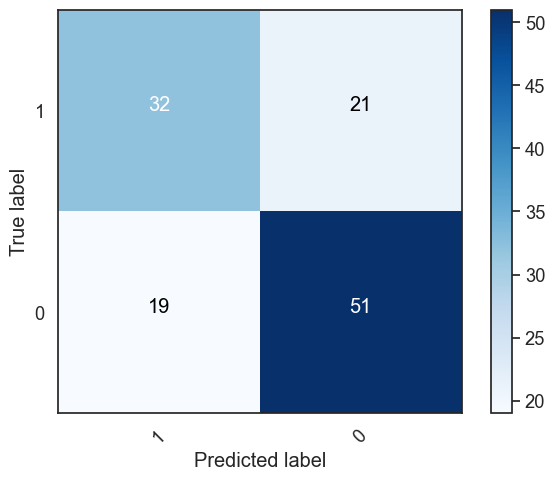

In [ ]:
plot_cm('theta', 'central', 'valence', 'knn')

[[42 11]
 [27 43]]
              precision    recall  f1-score   support

           0       0.61      0.79      0.69        53
           1       0.80      0.61      0.69        70

    accuracy                           0.69       123
   macro avg       0.70      0.70      0.69       123
weighted avg       0.72      0.69      0.69       123



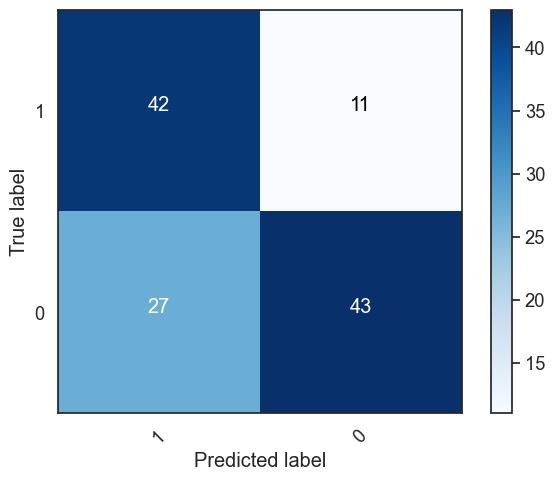

In [ ]:
plot_cm('beta', 'left', 'valence', 'knn')

[[33 20]
 [19 51]]
              precision    recall  f1-score   support

           0       0.63      0.62      0.63        53
           1       0.72      0.73      0.72        70

    accuracy                           0.68       123
   macro avg       0.68      0.68      0.68       123
weighted avg       0.68      0.68      0.68       123



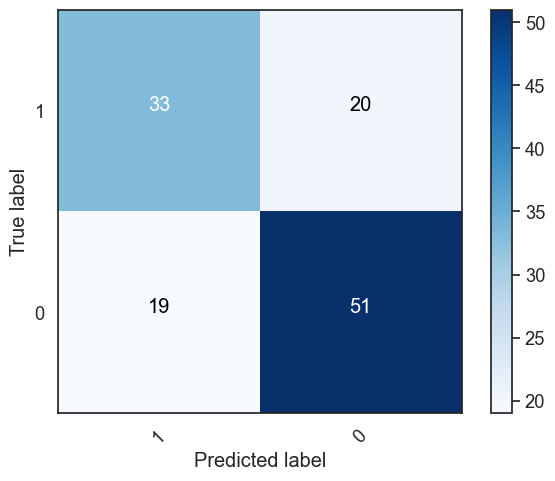

In [ ]:
plot_cm('gamma', 'right', 'valence', 'knn')

[[ 8 53]
 [ 6 56]]
              precision    recall  f1-score   support

           0       0.57      0.13      0.21        61
           1       0.51      0.90      0.65        62

    accuracy                           0.52       123
   macro avg       0.54      0.52      0.43       123
weighted avg       0.54      0.52      0.44       123



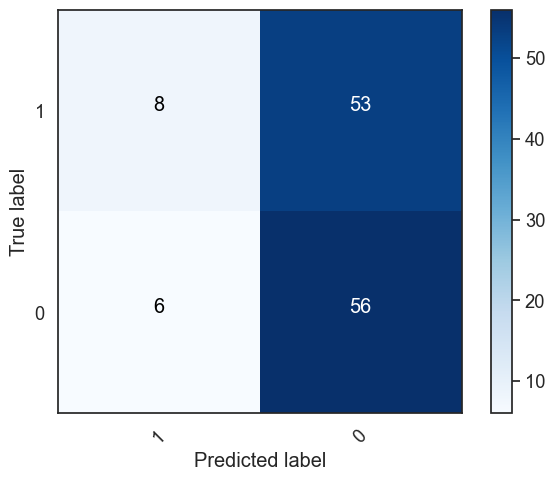

In [ ]:
plot_cm('alpha', 'central', 'arousal', 'svm')

[[14 47]
 [ 7 55]]
              precision    recall  f1-score   support

           0       0.67      0.23      0.34        61
           1       0.54      0.89      0.67        62

    accuracy                           0.56       123
   macro avg       0.60      0.56      0.51       123
weighted avg       0.60      0.56      0.51       123



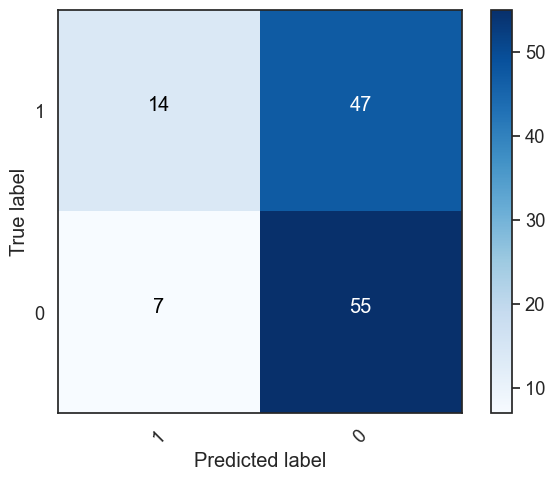

In [ ]:
plot_cm('theta', 'parietal', 'arousal', 'svm')